In [1]:
import pandas as pd
import numpy as np

path = "/Users/ianlent/Downloads/Investment_income_balance_detail.csv"

raw = pd.read_csv(
    path,
    skiprows=4,        # skip preamble (1-3) + header row (4)
    header=None,
    engine="python"
)

# Show first 2 rows so you can sanity-check alignment
raw.head(2)


,0,1,2,3,4,5,6,7,8,9
0,Jan 2026(As of Jan-29-2026),"$23,414.73","$4,997.09",$0.00,$0.00,$0.00,$0.00,$0.00,"$28,411.82","Ending balance: $28,411.82 Accrued interest..."
1,Dec 2025,"$23,189.31",-$287.91,$13.33,$0.00,$500.00,$0.00,$0.00,"$23,414.73","Ending balance: $23,414.73 Accrued interest..."


In [2]:
raw = raw.iloc[:, :10]  # keep first 10 columns (includes the notes column)

raw.columns = [
    "monthly",
    "beginning_balance",
    "market_change",
    "dividends",
    "interest",
    "deposits",
    "withdrawals",
    "net_advisory_fees",
    "ending_balance",
    "notes"
]

df = raw.drop(columns=["notes"])
df.head(3)


,monthly,beginning_balance,market_change,dividends,interest,deposits,withdrawals,net_advisory_fees,ending_balance
0,Jan 2026(As of Jan-29-2026),"$23,414.73","$4,997.09",$0.00,$0.00,$0.00,$0.00,$0.00,"$28,411.82"
1,Dec 2025,"$23,189.31",-$287.91,$13.33,$0.00,$500.00,$0.00,$0.00,"$23,414.73"
2,Nov 2025,"$20,109.11","$3,040.00",$40.20,$0.00,$0.00,$0.00,$0.00,"$23,189.31"


In [3]:
df["monthly"].head(10).tolist()


['Jan 2026(As of Jan-29-2026)',
 'Dec 2025',
 'Nov 2025',
 'Oct 2025',
 'Sep 2025',
 'Aug 2025',
 'Jul 2025',
 'Jun 2025',
 'May 2025',
 'Apr 2025']

In [4]:
df["month_str"] = df["monthly"].astype(str).str.extract(r"([A-Za-z]{3}\s+\d{4})", expand=False)
df["month"] = pd.to_datetime(df["month_str"], format="%b %Y")
df = df.sort_values("month").reset_index(drop=True)

df[["monthly", "month"]].head(19)


,monthly,month
0,Jul 2024(As of Jul-01-2024),2024-07-01
1,Aug 2024,2024-08-01
2,Sep 2024,2024-09-01
3,Oct 2024,2024-10-01
4,Nov 2024,2024-11-01
5,Dec 2024,2024-12-01
6,Jan 2025,2025-01-01
7,Feb 2025,2025-02-01
8,Mar 2025,2025-03-01
9,Apr 2025,2025-04-01


In [5]:
money_cols = [
    "beginning_balance","market_change","dividends","interest",
    "deposits","withdrawals","net_advisory_fees","ending_balance"
]

for c in money_cols:
    df[c] = (df[c].astype(str)
               .str.replace("$","", regex=False)
               .str.replace(",","", regex=False)
               .str.strip())
    df[c] = pd.to_numeric(df[c], errors="coerce")


In [6]:
df.head(1).to_dict()

{'monthly': {0: 'Jul 2024(As of Jul-01-2024)'},
 'beginning_balance': {0: 0.0},
 'market_change': {0: -575.57},
 'dividends': {0: 0.22},
 'interest': {0: 0.0},
 'deposits': {0: 7000.0},
 'withdrawals': {0: 0.0},
 'net_advisory_fees': {0: 0.0},
 'ending_balance': {0: 6424.65},
 'month_str': {0: 'Jul 2024'},
 'month': {0: Timestamp('2024-07-01 00:00:00')}}

In [7]:
df = df.sort_values("month").reset_index(drop=True)

df["pnl"] = df["market_change"] + df["dividends"] + df["interest"] - df["net_advisory_fees"]
df["capital_base"] = df["beginning_balance"] + df["deposits"]

# Avoid divide-by-zero (and protect that first inception row if capital_base is 0)
df["ret"] = np.where(df["capital_base"] > 0, df["pnl"] / df["capital_base"], np.nan)

df[["month","beginning_balance","deposits","pnl","capital_base","ret","ending_balance"]].head(19)


,month,beginning_balance,deposits,pnl,capital_base,ret,ending_balance
0,2024-07-01,0.00,7000.0,-575.35,7000.00,-0.082193,6424.65
1,2024-08-01,6424.65,0.0,201.49,6424.65,0.031362,6626.14
2,2024-09-01,6626.14,0.0,215.92,6626.14,0.032586,6842.06
3,2024-10-01,6842.06,0.0,576.96,6842.06,0.084325,7419.02
4,2024-11-01,7419.02,0.0,853.07,7419.02,0.114984,8272.09
5,2024-12-01,8272.09,0.0,-76.23,8272.09,-0.009215,8195.86
6,2025-01-01,8195.86,0.0,1357.37,8195.86,0.165617,9553.23
7,2025-02-01,9553.23,0.0,760.01,9553.23,0.079555,10314.04
8,2025-03-01,10314.04,0.0,-1361.46,10314.04,-0.132001,8962.86
9,2025-04-01,8962.86,2000.0,1153.96,10962.86,0.105261,12116.82


In [8]:
rets = df["ret"].dropna()


In [9]:
import numpy as np

vol_annual = rets.std(ddof=1) * np.sqrt(12)
vol_annual


np.float64(0.46185628319152716)

In [10]:
sharpe = (rets.mean() / rets.std(ddof=1)) * np.sqrt(12)
sharpe


np.float64(1.781614143117713)

In [11]:
downside = rets[rets < 0].std(ddof=1)
sortino = (rets.mean() / downside) * np.sqrt(12)
sortino


np.float64(3.69571688392705)

In [12]:
n_months = len(rets)
cagr = (1 + rets).prod() ** (12 / n_months) - 1
cagr


np.float64(1.0264646854563004)

In [13]:
df["cum"] = (1 + df["ret"]).cumprod()
df["peak"] = df["cum"].cummax()
df["drawdown"] = df["cum"] / df["peak"] - 1

max_dd = df["drawdown"].min()
max_dd


np.float64(-0.1704099583722154)

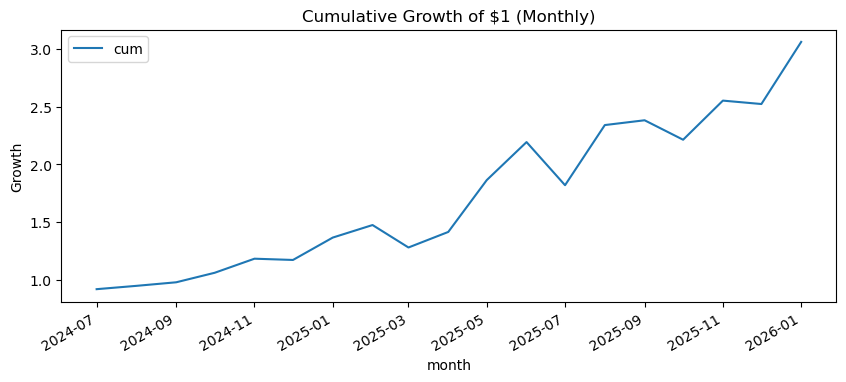

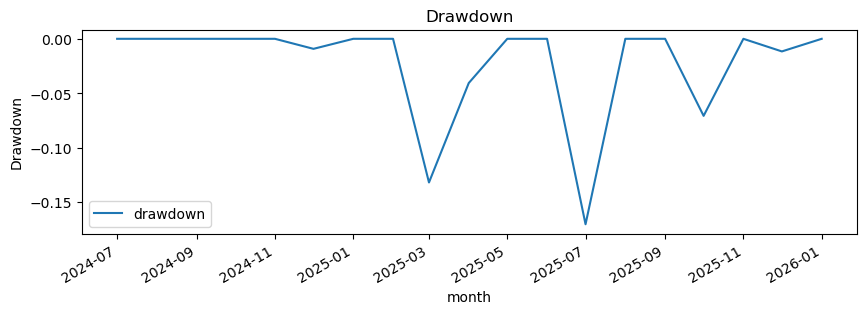

In [14]:
import matplotlib.pyplot as plt

df.set_index("month")[["cum"]].plot(figsize=(10,4))
plt.title("Cumulative Growth of $1 (Monthly)")
plt.ylabel("Growth")
plt.show()

df.set_index("month")[["drawdown"]].plot(figsize=(10,3))
plt.title("Drawdown")
plt.ylabel("Drawdown")
plt.show()


In [15]:
metrics = pd.DataFrame({
    "Metric": [
        "CAGR",
        "Annualized Volatility",
        "Sharpe Ratio",
        "Sortino Ratio",
        "Max Drawdown",
        "Hit Rate (% Positive Months)"
    ],
    "Portfolio": [
        f"{cagr:.2%}",
        f"{vol_annual:.2%}",
        f"{sharpe:.2f}",
        f"{sortino:.2f}",
        f"{max_dd:.2%}",
        f"{(df['ret'] > 0).mean():.1%}"
    ]
})

metrics


,Metric,Portfolio
0,CAGR,102.65%
1,Annualized Volatility,46.19%
2,Sharpe Ratio,1.78
3,Sortino Ratio,3.70
4,Max Drawdown,-17.04%
5,Hit Rate (% Positive Months),35.1%
